## Quickstart Template

You've now learned what Alphalens is and how to use it. Clone this lesson's notebook to start analyzing factors of your own!

Below is an explanation of each block of code in the notebook. The notebook does not contain these explanations. 

## Define An Alpha Factor
The attached notebook is set up to analyze the alpha factor called `factor_to_analyze` in the pipeline below.

If you're confused: Don't worry, you only have to change one line of code in the entire notebook to get started!

Trying altering this line of code: `factor_to_analyze = (current_assets - assets_moving_average)` to analyze a data field from our list of Fundamental data fields from FactSet. For example, you could change that line to `factor_to_analyze = factset.Fundamentals.assets_gr_qf.latest`, then run the rest of the cells in the notebook. By modifying that one line of code, you're now analyzing how a company's asset growth affects its stock price! 

In [1]:
from zipline.pipeline.fundamentals import Fundamentals

from zipline.pipeline import Pipeline
from zipline.research import run_pipeline
from zipline.pipeline.factors import CustomFactor, SimpleMovingAverage
# 自builtin导入
from zipline.pipeline.builtin import QTradableStocksUS, Sector
from zipline.pipeline.data import EquityPricing
from alphalens.tears import create_information_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

In [2]:
from zipline.research import get_pricing

In [3]:
def make_pipeline():

    assets_moving_average = SimpleMovingAverage(inputs=[Fundamentals.balance_sheet.资产总计], window_length=252)
    current_assets = Fundamentals.balance_sheet.资产总计.latest

    factor_to_analyze = (current_assets - assets_moving_average)

    sector = Sector()

    return Pipeline(
        columns={'factor_to_analyze': factor_to_analyze, 'sector': sector},
        screen=QTradableStocksUS() & factor_to_analyze.notnull() & sector.notnull()
    )

factor_data = run_pipeline(make_pipeline(), '2015-1-1', '2016-1-1')
pricing_data = get_pricing(factor_data.index.levels[1], '2015-1-1', '2016-6-1', fields='open')

## Determine The Decay Rate Of The Alpha Factor
The following chart shows your alpha factor's Information Coefficient over time. As a reminder, the IC is the most useful number for quantifying a given alpha factor's predictiveness. 

In [4]:
from alphalens.performance import mean_information_coefficient
from alphalens.tears import create_returns_tear_sheet

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


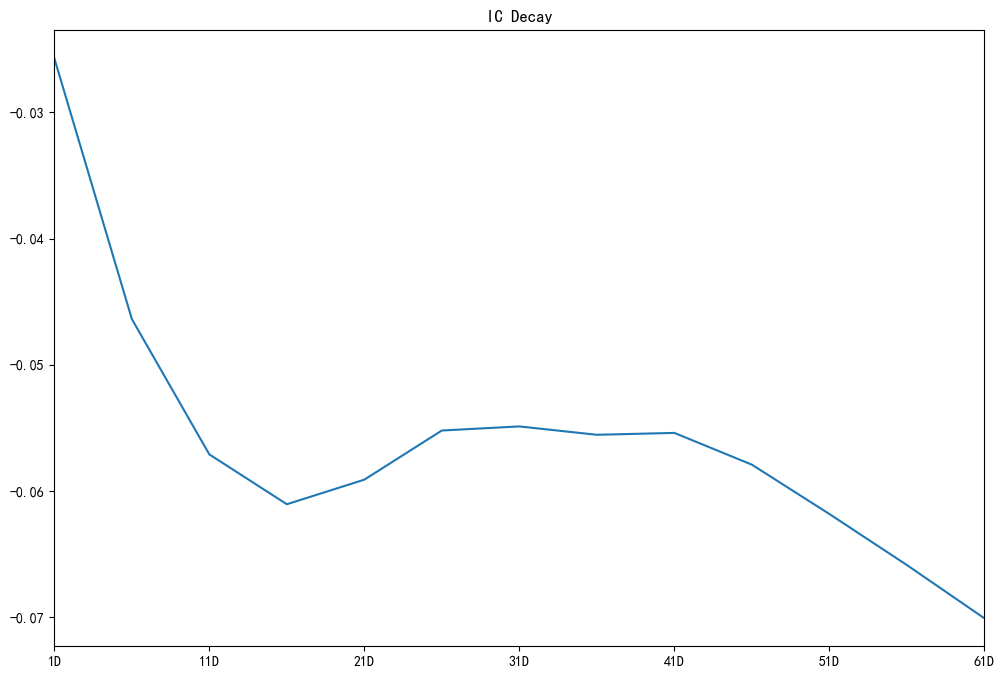

In [5]:
longest_look_forward_period = 63 # week = 5, month = 21, quarter = 63, year = 252
range_step = 5

merged_data = get_clean_factor_and_forward_returns(
    factor=factor_data['factor_to_analyze'],
    prices=pricing_data,
    periods=range(1, longest_look_forward_period, range_step)
)

mean_information_coefficient(merged_data).plot(title="IC Decay")

## Create Group Neutral Tear Sheets
Run the following cells to create group neutral tear sheets for your alpha factor. If you don't know what group neutral means, please refer back to `lesson 4` of this tutorial.

Ideally, you want the IC Mean line chart to constantly be above 0. You also want to see Quantile 1 consistently have the lowest returns, and quantile 5 consistently have the highest returns.

Lastly, be sure to take a look at the IC Mean and returns by sector to see if there are any major outliers in terms of performace. 

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
信息系数分析


,1D,5D,10D
IC平均值,-0.014,-0.027,-0.039
IC标准差,0.086,0.103,0.114
风险调整后的IC,-0.161,-0.265,-0.338
t-统计(IC),-2.522,-4.144,-5.283
p值(IC),0.012,0.000,0.000
IC偏度,0.532,0.668,1.057
IC峰度,0.368,0.534,0.686


<Figure size 1200x800 with 0 Axes>

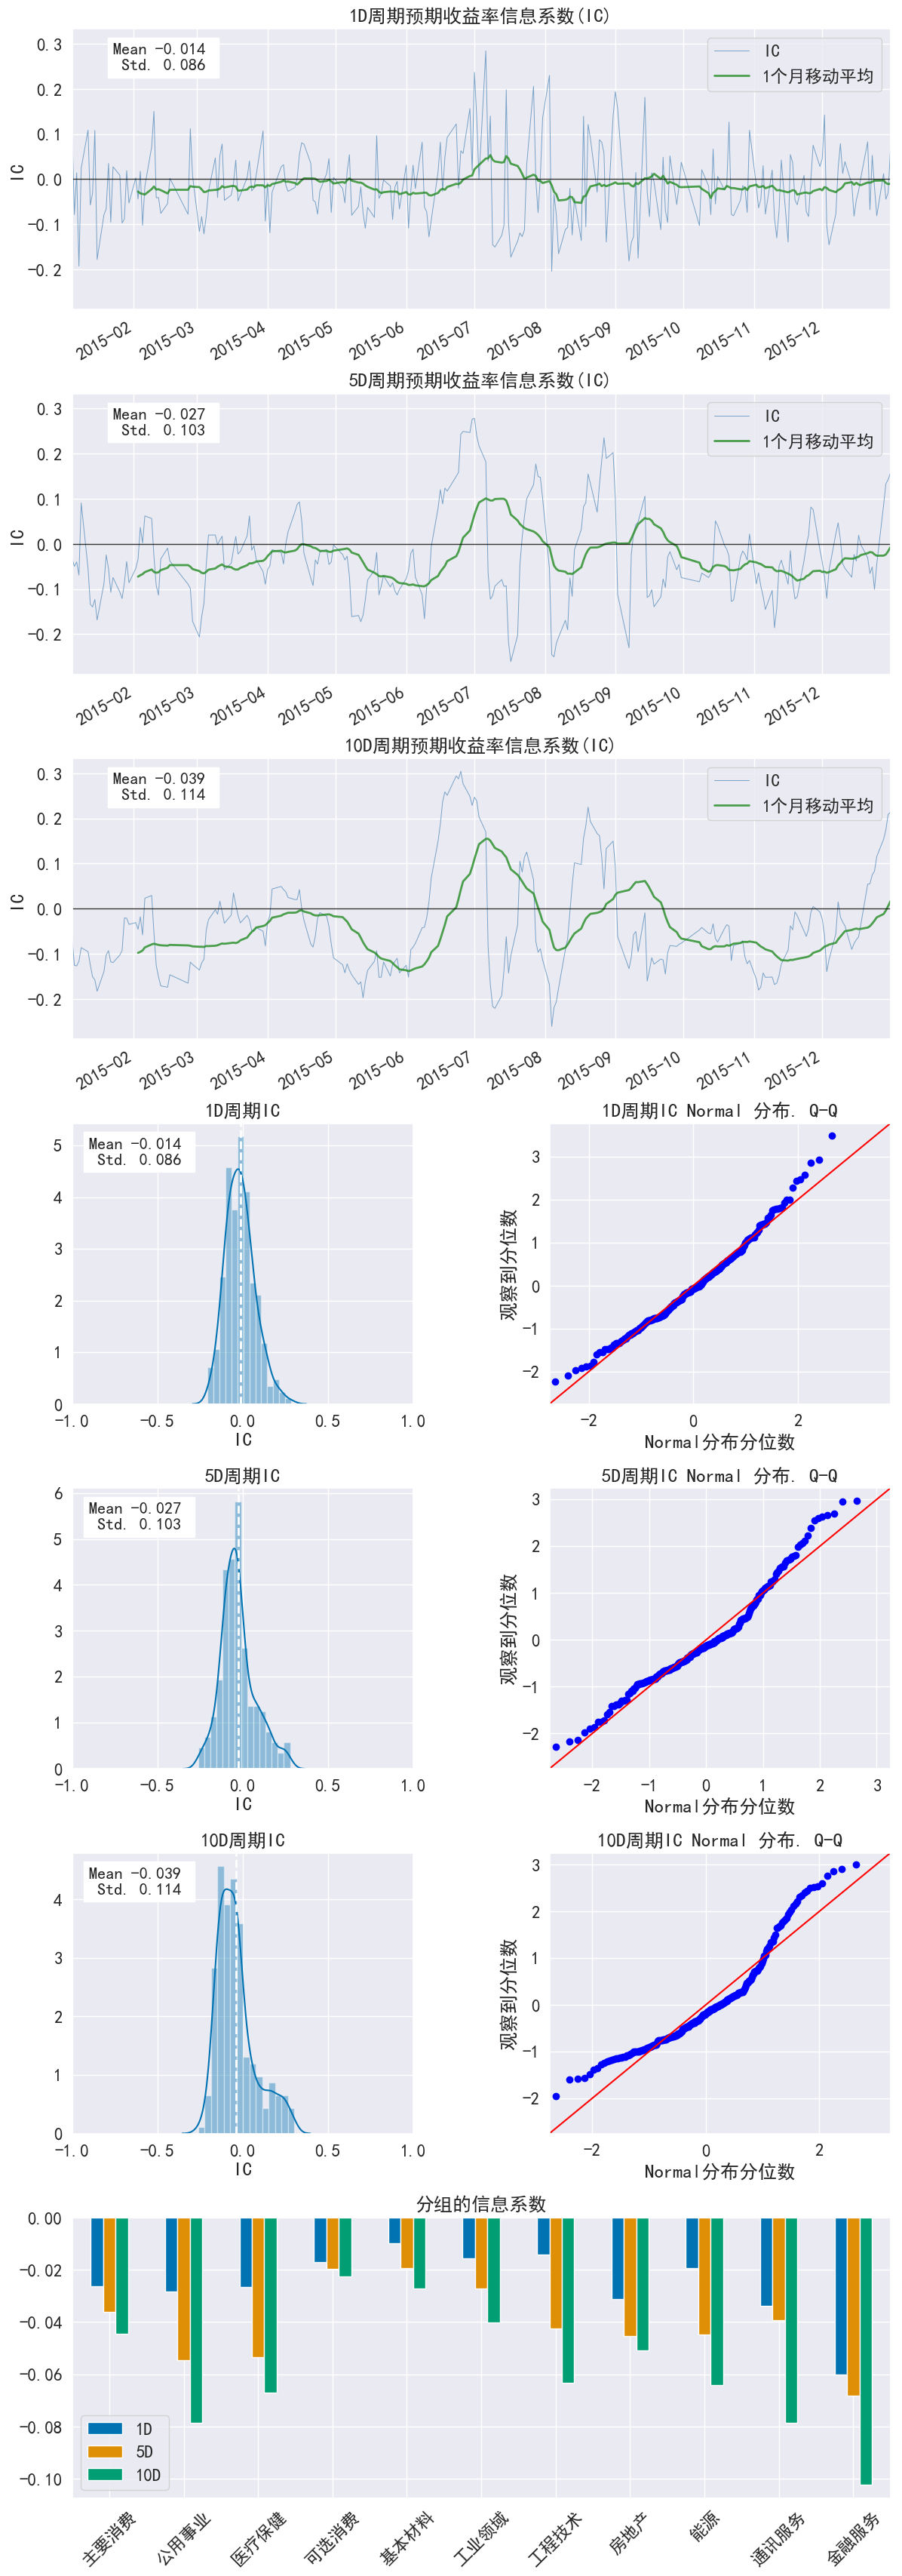

收益率分析


,1D,5D,10D
Ann. alpha,-0.099,-0.092,-0.094
beta,-0.151,-0.177,-0.184
最高分位数周期平均收益率(基点),-9.256,-8.550,-8.310
最低分位数周期平均收益率(基点),-0.942,-0.235,0.147
周期平均展布(基点),-8.314,-8.561,-8.777


<Figure size 1200x800 with 0 Axes>

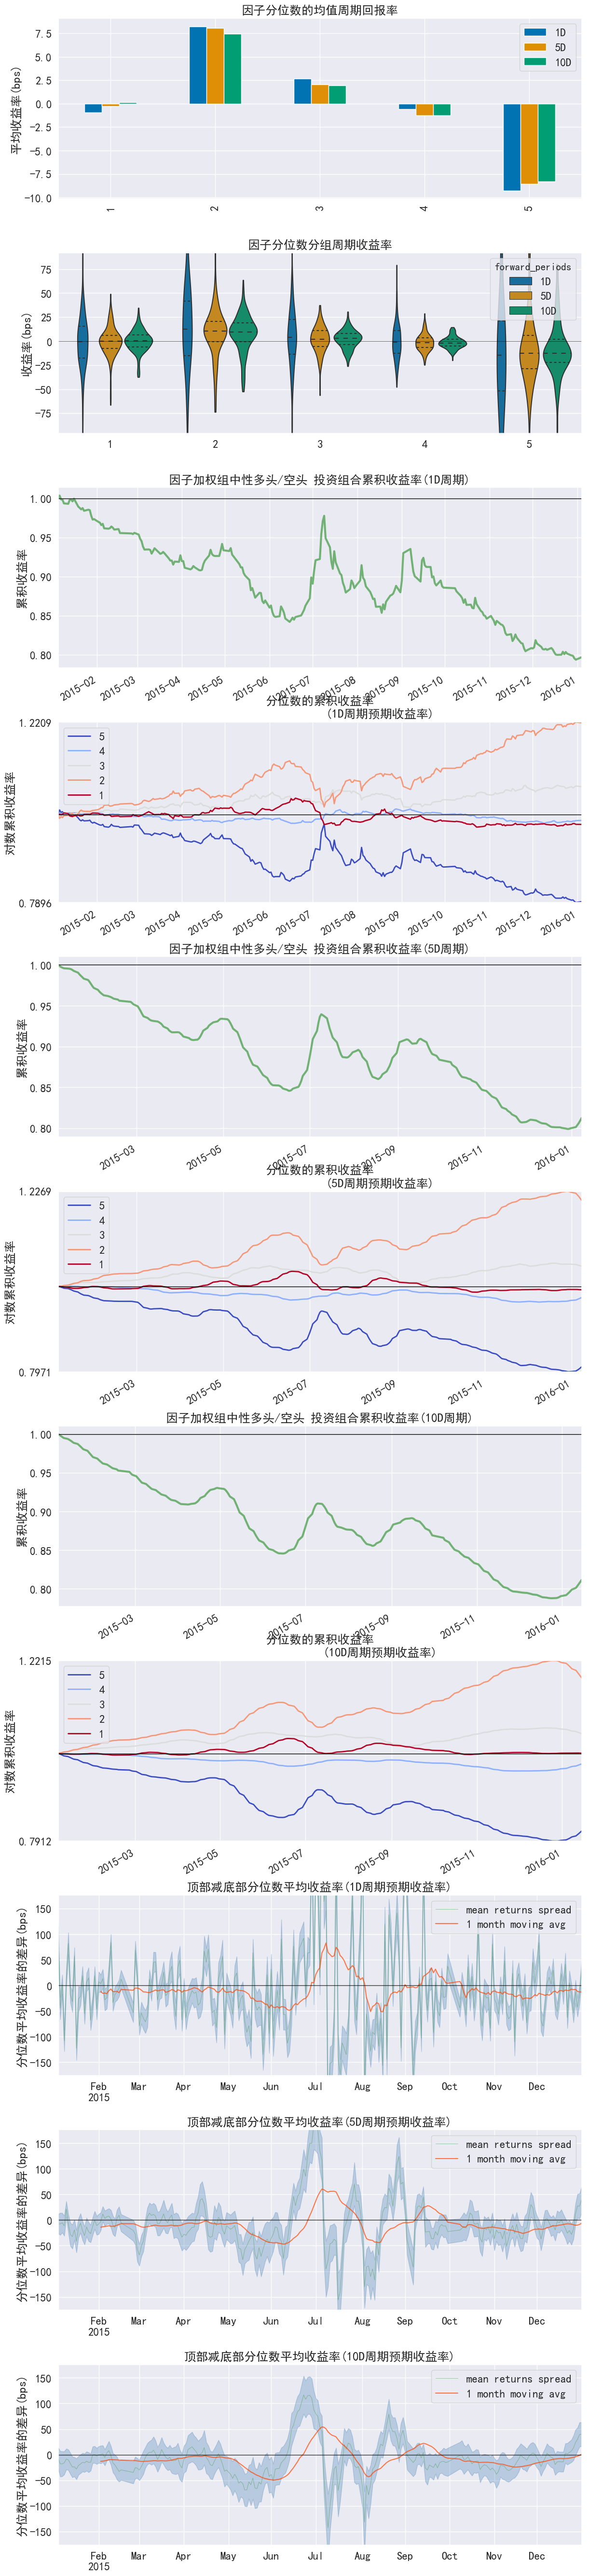

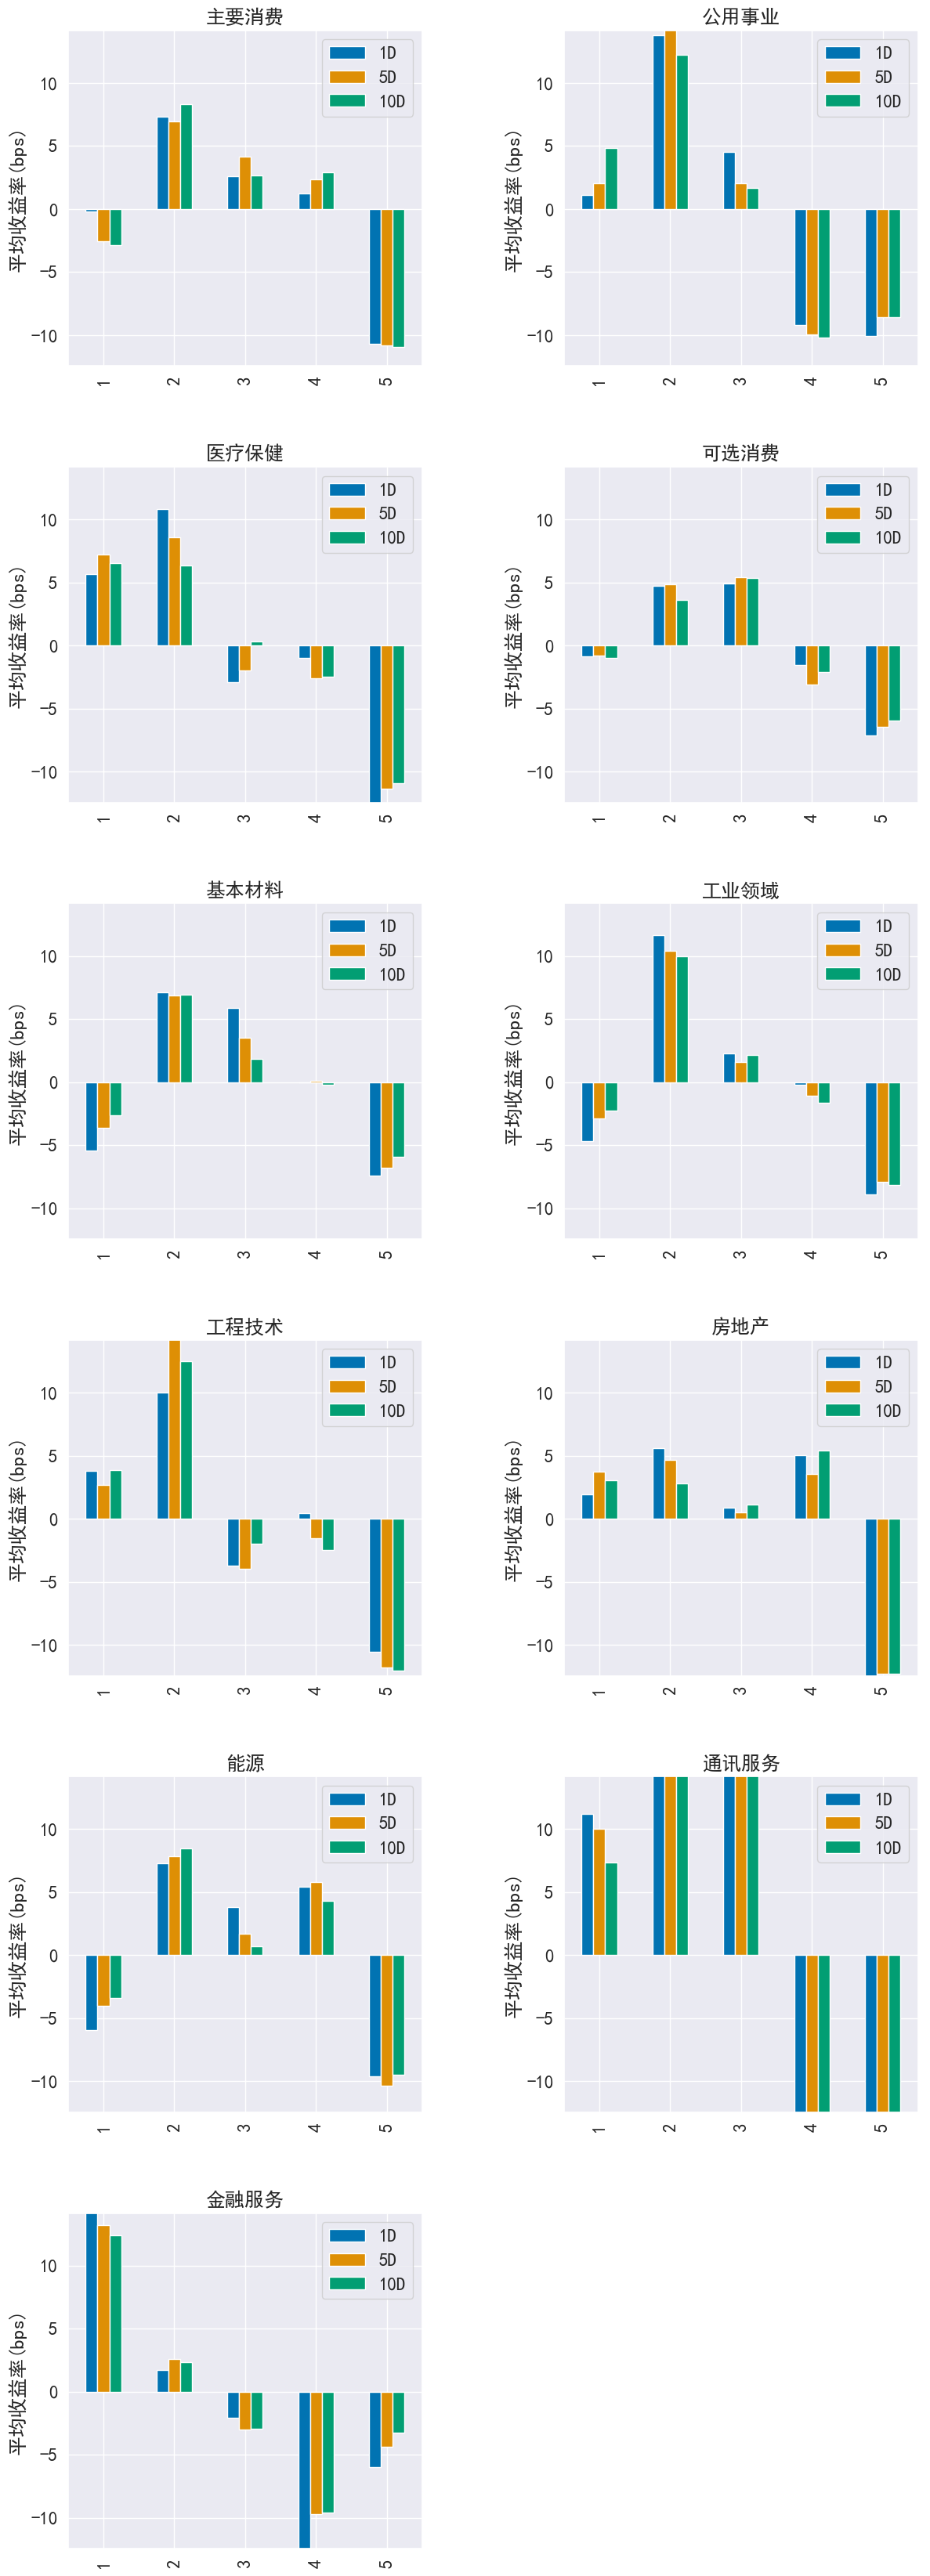

In [6]:
sector_labels, sector_labels[-1] = dict(Sector.SECTOR_NAMES), "Unknown"

merged_data = get_clean_factor_and_forward_returns(
    factor=factor_data['factor_to_analyze'],
    prices=pricing_data,
    groupby=factor_data['sector'],
    groupby_labels=sector_labels,
    binning_by_group=True,
    periods=(1,5,10)
)

create_information_tear_sheet(merged_data, by_group=True, group_neutral=True)
create_returns_tear_sheet(merged_data, by_group=True, group_neutral=True)